In this notebook, I will use XGBoost to create a pricing model that can enable us estimate the price range of a shipment, given a set of features

In [226]:
# importing libaries
import pandas as pd
import numpy as np 
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



In [227]:
# assigning file path to variable
data = r"clean_data.csv"

In [228]:
# loading data to dataframe
clean_df = pd.read_csv(data)

In [229]:
#checking for null values
clean_df.isna().sum()

carrier_number                     0
shipment_number                    0
shipment_date                      0
delivery_date                      0
delivery_reliability               0
feedback_reliability               0
non_conformance_count              0
transport_mode                     0
cost_usd                           0
region                             0
origin_country                     0
origin_postal_code                 0
destination_country                0
destination_postal_code            0
distance_km                        0
lead_time_days                     0
co2_emission_kg                    0
shipment_weight_kg                 0
first_carrier_name                 0
carrier_number_name                0
year_month                         0
price_per_distance                 0
origin_postal_code_2_digit         0
destination_postal_code_2_digit    0
lane                               0
country_lane                       0
dtype: int64

In [230]:
# dF info
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14923 entries, 0 to 14922
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   carrier_number                   14923 non-null  object 
 1   shipment_number                  14923 non-null  object 
 2   shipment_date                    14923 non-null  object 
 3   delivery_date                    14923 non-null  object 
 4   delivery_reliability             14923 non-null  int64  
 5   feedback_reliability             14923 non-null  int64  
 6   non_conformance_count            14923 non-null  int64  
 7   transport_mode                   14923 non-null  object 
 8   cost_usd                         14923 non-null  float64
 9   region                           14923 non-null  object 
 10  origin_country                   14923 non-null  object 
 11  origin_postal_code               14923 non-null  int64  
 12  destination_countr

In [231]:
# converting useful columns to string type
clean_df[['origin_postal_code_2_digit','destination_postal_code_2_digit' ]] = clean_df[['origin_postal_code_2_digit','destination_postal_code_2_digit' ]].astype(str)

In [232]:
#spot check
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14923 entries, 0 to 14922
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   carrier_number                   14923 non-null  object 
 1   shipment_number                  14923 non-null  object 
 2   shipment_date                    14923 non-null  object 
 3   delivery_date                    14923 non-null  object 
 4   delivery_reliability             14923 non-null  int64  
 5   feedback_reliability             14923 non-null  int64  
 6   non_conformance_count            14923 non-null  int64  
 7   transport_mode                   14923 non-null  object 
 8   cost_usd                         14923 non-null  float64
 9   region                           14923 non-null  object 
 10  origin_country                   14923 non-null  object 
 11  origin_postal_code               14923 non-null  int64  
 12  destination_countr

Building a Heatmap

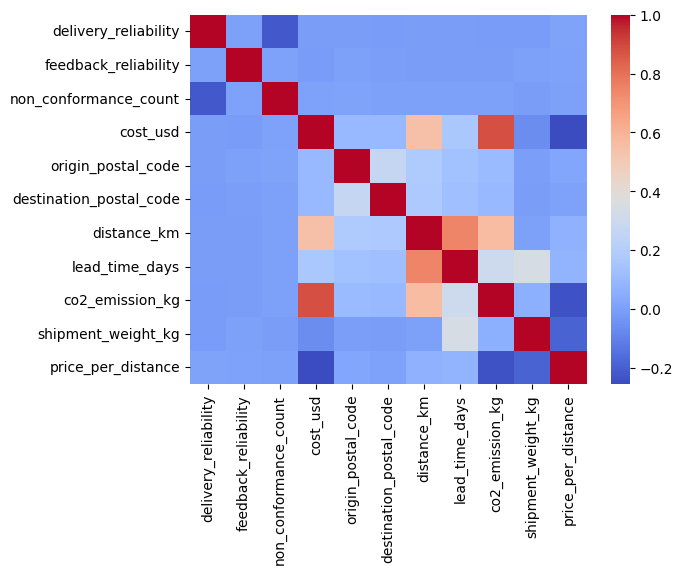

In [233]:
sns.heatmap(clean_df.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.show()


Based on domain knowledge, and data from the heatmap, I will use the following as the initial features:
* carrier_number_name,
* co2_emission_kg,
* distance_km, 
* transport_mode, 
* cost_usd

In [234]:
# creating a new dataframe for the useful columns
selected_features = clean_df[['carrier_number_name', 'co2_emission_kg', 'distance_km', 'transport_mode', 'cost_usd','origin_country', 'destination_country' ,'origin_postal_code_2_digit','destination_postal_code_2_digit' ]]

In [235]:
#df info
selected_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14923 entries, 0 to 14922
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   carrier_number_name              14923 non-null  object 
 1   co2_emission_kg                  14923 non-null  float64
 2   distance_km                      14923 non-null  float64
 3   transport_mode                   14923 non-null  object 
 4   cost_usd                         14923 non-null  float64
 5   origin_country                   14923 non-null  object 
 6   destination_country              14923 non-null  object 
 7   origin_postal_code_2_digit       14923 non-null  object 
 8   destination_postal_code_2_digit  14923 non-null  object 
dtypes: float64(3), object(6)
memory usage: 1.0+ MB


Splitting Data into training, val and test sets

In [236]:
X_data = selected_features.drop('cost_usd', axis='columns') # features
y_data = selected_features['cost_usd'] #target

In [237]:
# splitting data into training, valuation and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, train_size=0.8, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, random_state=42)

In [238]:
#processing data using pipeline

num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns  # Adjust for continuous
cat_cols = X_train.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols)
    ]
)

X_train_enc = preprocessor.fit_transform(X_train)
X_val_enc = preprocessor.transform(X_val)  

In [239]:
# spot check
X_train_enc.shape

(11938, 8)

In [240]:
# defining model based on XGBRegressor parameters
model = XGBRegressor(n_estimators=100, early_stopping=50, eval_metric='rmse', max_depth=3, reg_alpha=0.1, random_state=42)


# fitting model to training set
model.fit(X_train_enc, y_train)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [11:42:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "early_stopping" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


In [241]:
# predicting  training set prices based on Training features
y_train_pred = model.predict(X_train_enc)

In [242]:
# root mean squared error for training set
rsme = np.sqrt(mse(y_train_pred, y_train))
rsme

np.float64(5834.494036939675)

In [243]:
# R2 Score
r2_score(y_train_pred, y_train)

0.9093463994643406

In [244]:
# predicting  validation set prices based on validation features
y_val_pred = model.predict(X_val_enc)

In [245]:
# root mean squared error for validation set
val_rsme = np.sqrt(mse(y_val_pred, y_val))
val_rsme

np.float64(7435.868763418295)

In [246]:
# R2 Score
r2_score(y_val_pred, y_val)

0.8488776368941692

In [247]:
# transforming Test features
X_test_enc = preprocessor.transform(X_test)  

In [248]:
# predicting  validation set prices based on test features
y_test_pred = model.predict(X_test_enc)

In [249]:
# root mean squared error for test set
test_rsme = np.sqrt(mse(y_test_pred, y_test))
test_rsme

np.float64(7647.732345480941)

In [250]:
# R2 Score
r2_score(y_test_pred, y_test)

0.851160356720099

Plotting KDE Plots

Text(0.5, 1.0, 'KDE Plot - Training Set')

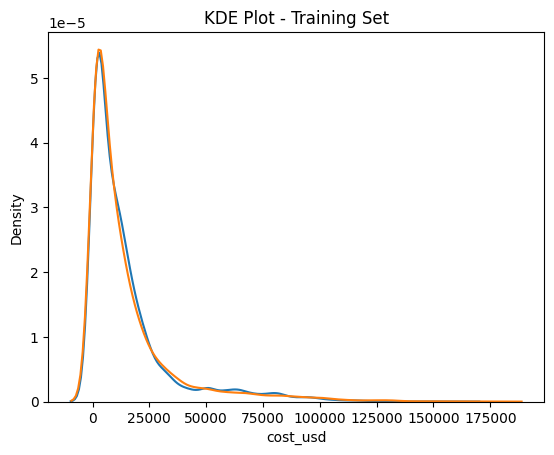

In [251]:
ax1 = sns.kdeplot(y_train_pred)
sns.kdeplot(y_train, ax=ax1)
plt.title("KDE Plot - Training Set")

Text(0.5, 1.0, 'KDE Plot - Validation Set')

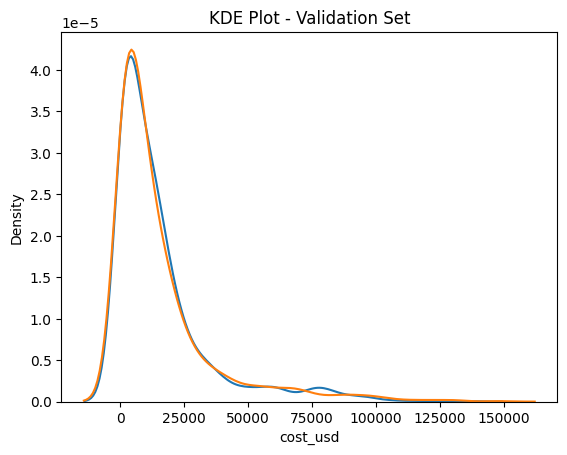

In [252]:
ax1 = sns.kdeplot(y_val_pred)
sns.kdeplot(y_val, ax=ax1)
plt.title("KDE Plot - Validation Set")

Text(0.5, 1.0, 'KDE Plot - Test Set')

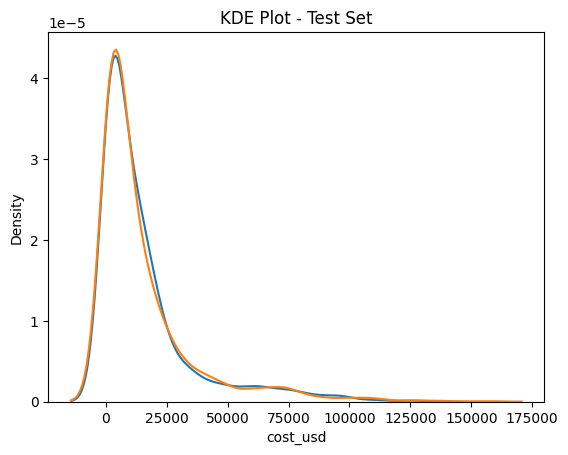

In [253]:
ax1 = sns.kdeplot(y_test_pred)
sns.kdeplot(y_test, ax=ax1)
plt.title("KDE Plot - Test Set")

Eliminating Outliers to see the effect on the model's performance

In [254]:
# determining upper bounds
mode_upper_bound = {}
for mode in selected_features['transport_mode'].unique():
    q1 = selected_features[selected_features['transport_mode'] == mode]['cost_usd'].quantile(0.25)
    q3 = selected_features[selected_features['transport_mode'] == mode]['cost_usd'].quantile(0.75)
    iqr = q3-q1
    upper_bound = q3 + (1.5 * iqr)

    mode_upper_bound[mode]  = upper_bound
    print(mode)
    print(f"upper bound = {upper_bound}")

Road
upper bound = 38472.005
Sea
upper bound = 32087.61
Air
upper bound = 100701.70374999999
Rail
upper bound = 33990.042499999996


In [255]:
mode_upper_bound

{'Road': np.float64(38472.005),
 'Sea': np.float64(32087.61),
 'Air': np.float64(100701.70374999999),
 'Rail': np.float64(33990.042499999996)}

Filtering for the upper bound of each transport mode

In [256]:
trimmed_features_road = selected_features[(selected_features['transport_mode'] == 'Road') & (selected_features['cost_usd'] <= mode_upper_bound['Road'])]

In [257]:
trimmed_features_sea = selected_features[(selected_features['transport_mode'] == 'Sea') & (selected_features['cost_usd'] <= mode_upper_bound['Sea'])]

In [258]:
trimmed_features_air = selected_features[(selected_features['transport_mode'] == 'Air') & (selected_features['cost_usd'] <= mode_upper_bound['Air'])]

In [259]:
trimmed_features_rail = selected_features[(selected_features['transport_mode'] == 'Rail') & (selected_features['cost_usd'] <= mode_upper_bound['Rail'])]

In [260]:
# spot check
trimmed_features_road['cost_usd'].max()

np.float64(38439.18)

In [261]:
# spot check
trimmed_features_sea['cost_usd'].max()

np.float64(31928.13)

In [262]:
# spot check
trimmed_features_air['cost_usd'].max()

np.float64(100520.88)

In [263]:
# spot check
trimmed_features_rail['cost_usd'].max()

np.float64(33702.45)

In [264]:
trimmed_features = pd.concat([trimmed_features_road,trimmed_features_sea, trimmed_features_rail,trimmed_features_air])

In [265]:
trimmed_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14070 entries, 0 to 14917
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   carrier_number_name              14070 non-null  object 
 1   co2_emission_kg                  14070 non-null  float64
 2   distance_km                      14070 non-null  float64
 3   transport_mode                   14070 non-null  object 
 4   cost_usd                         14070 non-null  float64
 5   origin_country                   14070 non-null  object 
 6   destination_country              14070 non-null  object 
 7   origin_postal_code_2_digit       14070 non-null  object 
 8   destination_postal_code_2_digit  14070 non-null  object 
dtypes: float64(3), object(6)
memory usage: 1.1+ MB


In [266]:
selected_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14923 entries, 0 to 14922
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   carrier_number_name              14923 non-null  object 
 1   co2_emission_kg                  14923 non-null  float64
 2   distance_km                      14923 non-null  float64
 3   transport_mode                   14923 non-null  object 
 4   cost_usd                         14923 non-null  float64
 5   origin_country                   14923 non-null  object 
 6   destination_country              14923 non-null  object 
 7   origin_postal_code_2_digit       14923 non-null  object 
 8   destination_postal_code_2_digit  14923 non-null  object 
dtypes: float64(3), object(6)
memory usage: 1.0+ MB


Splitting Data

In [267]:
X_trimmed_data = trimmed_features.drop('cost_usd',axis='columns')
y_trimmed_data = trimmed_features['cost_usd']

In [268]:
X_trimmed_train, X_trimmed_temp, y_trimmed_train, y_trimmed_temp = train_test_split(X_trimmed_data, y_trimmed_data, test_size=0.2, random_state=42)
X_trimmed_val, X_trimmed_test, y_trimmed_val, y_trimmed_test = train_test_split(X_trimmed_temp, y_trimmed_temp, test_size=0.5, random_state=42)

In [269]:
#processing data using pipeline

num_cols = X_trimmed_train.select_dtypes(include=['float64', 'int64']).columns  # Adjust for continuous
cat_cols = X_trimmed_train.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols)
    ]
)

X_trimmed_train_enc = preprocessor.fit_transform(X_trimmed_train)
X_trimmed_val_enc = preprocessor.transform(X_trimmed_val)  

In [270]:
# defining model based on XGBRegressor parameters
model = XGBRegressor(n_estimators=100, early_stopping=50, eval_metric='rmse', max_depth=3, reg_alpha=0.1, random_state=42)


# fitting model to training set
model.fit(X_trimmed_train_enc, y_trimmed_train)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [11:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "early_stopping" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


In [271]:
# predicting  training set prices based on Training features
y_trimmed_train_pred = model.predict(X_trimmed_train_enc)

In [272]:
r2_score(y_trimmed_train_pred, y_trimmed_train)

0.915595998860099

In [273]:
y_trimmed_val_pred = model.predict(X_trimmed_val_enc)

In [274]:
r2_score(y_trimmed_val_pred, y_trimmed_val)

0.8728954592973477

In [275]:
trimmed_rsme = np.sqrt(mse(y_trimmed_train_pred, y_trimmed_train))
trimmed_rsme

np.float64(4074.4683336184803)

In [276]:
trimmed_val_rsme = np.sqrt(mse(y_trimmed_val_pred, y_trimmed_val))
trimmed_val_rsme

np.float64(5018.67718332082)

In [279]:
(trimmed_rsme-rsme)/rsme *100

np.float64(-30.16586686314223)

In [282]:
(trimmed_val_rsme-val_rsme)/val_rsme *100

np.float64(-32.50718452683239)

In [280]:
# splitting data into training, valuation and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, train_size=0.8, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, random_state=42)

The RMSE dropped by 30% for training sets and 32% for val sets after trimming the data using the upper_bound derived from the IQR

Hyper Parameter Tuning - XGBRegressor

In [290]:
from sklearn.model_selection import GridSearchCV

xgb = XGBRegressor(objective='reg:squarederror')

param_grid = {
    'max_depth': [3, 5, 10],      # Shallower = less overfit
    'learning_rate': [0.01, 0.1, 0.3],  # Step size
    'n_estimators': [100, 200] ,   # Trees
   
}

# GridSearch: CV=3 for speed (5 for thorough)
grid = GridSearchCV(
    xgb, param_grid,  # Or pipeline
    cv=3,             # Folds
    scoring='r2',     # Or 'neg_mean_squared_error' for RMSE
    n_jobs=-1,        # Parallel
    verbose=1         # Progress
)

# Fit & get best
grid.fit(X_trimmed_train_enc, y_trimmed_train)  # Or pipeline.fit(X_train, y_train)

# Results
print("Best params:", grid.best_params_)
print("Best CV R²:", grid.best_score_)
print("Best model:", grid.best_estimator_)

# Predict on val
y_trimmed_val_pred = grid.predict(X_trimmed_val_enc)
print("Val R²:", r2_score(y_trimmed_val, y_trimmed_val_pred))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best CV R²: 0.8947624601113914
Best model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)
Val R²: 0.889671181278864


In [291]:
import joblib

# Save the best model (or pipeline)
joblib.dump(grid.best_estimator_, 'xgb_tuned_model.pkl')  # .pkl extension common
print("Model saved as 'xgb_tuned_model.pkl'")

Model saved as 'xgb_tuned_model.pkl'


In [ ]:
# Save the fitted preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')
print("Preprocessor saved as 'preprocessor.pkl'")

Preprocessor saved as 'preprocessor.pkl'


Exception ignored in: <function ResourceTracker.__del__ at 0x108bbdbc0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1078b1bc0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/m

In [293]:
# Install if needed (run once)
!pip install shap

# Imports
import shap



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [294]:
# Create explainer
explainer = shap.TreeExplainer(grid.best_estimator_)

# Compute on a sample (e.g., val data; use subset for large sets)
shap_values = explainer.shap_values(X_trimmed_val_enc[:100])  # Limit to 100 rows

# Check shape: (n_samples, n_features)
print(shap_values.shape)

(100, 8)


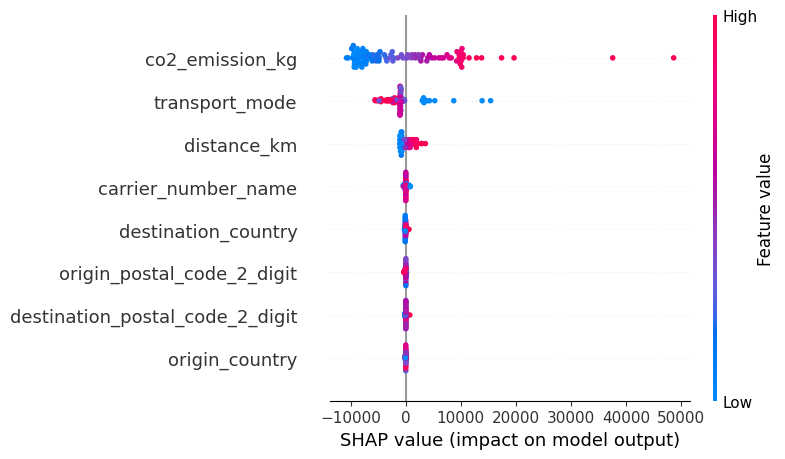

In [298]:
# Feature names (from your cols)
feature_names = list(num_cols) + list(cat_cols)

# Beeswarm plot (red = high feature value boosts pred)
shap.summary_plot(shap_values, X_trimmed_val_enc[:100], feature_names=feature_names)

